In [26]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple, defaultdict

from robustness import logger
logger.setLevel('INFO')

from robustness import NETWORKS_DIR
from robustness.mpl_settings_v3 import *
from robustness.planar import create_proximity_graph
from robustness.auxiliary import (
    getLinearReg, 
    get_base_network_name, 
    powerlaw, 
    load_delta_data, 
    read_data_file
)
from robustness.plot_auxiliary import (
    letters,
    attack_dict,
    fig_dir, 
    load_delta,
    load_deltas,
    load_dataframe, 
    get_critical_measures,
    getPeaks,
    compute_fc_v2,
    get_rc_values,
    get_l_cutoff,
    load_comp_sizes_data
)

%matplotlib inline

net_type = 'DT'
param = 'param'

net_dir = os.path.join('..', 'networks', net_type)

marker_dict = {'num': 'o', 'Nsec': 's', 'varSgcc': '^', 'Sgcc': '*'}
color_dict = {'num': 'C0', 'Nsec': 'C1', 'varSgcc': 'C2', 'Sgcc': 'C3'}
linestyle_dict = {'num': '--', 'Nsec': '-.', 'varSgcc': ':', 'Sgcc': ':'}
measures_dict = {'num': r'$M_2$', 'meanS': r'$\langle s \rangle$', 'Nsec': r'$S_2 L^2$', 'varSgcc': r'$\chi$', 'Sgcc': r'$N_1$'}
line_colors = {'num': 'k', 'Nsec': 'grey', 'varSgcc': 'brown', 'Sgcc': 'C8'}

In [4]:
def load_dataframes(net_type, param, sizes, attack, min_nseeds=None, nseeds=None):
    dfs = {}
    for N in sizes:
        try:
            dfs[N] = load_dataframe(
                net_type, N, param, attack, 
                min_nseeds=min_nseeds, nseeds=nseeds
            )
        except FileNotFoundError:
            continue
    return dfs

In [51]:
gamma_measures = ['num', 'meanS']
beta_measures = ['Nsec']
measures = gamma_measures + beta_measures
attacks = [
    'Btw_cutoff2'
]
navg = 5
nseeds = 10000
min_nseeds = None
sizes = [
    256, 512, 
    1024, 
    2048, 
    4096, 8192, 16384, 
    32768, 65536, 131072, 262144
]
data = {}
for k, attack in enumerate(attacks):
    data[attack] = defaultdict(list)
    dfs = load_dataframes(net_type, param, sizes, attack, min_nseeds=min_nseeds, nseeds=nseeds)
    N_values = np.array(list(dfs.keys()))
    L_values = np.sqrt(N_values)
    for i, measure in enumerate(measures):
        measure_values = get_critical_measures(
            dfs, measure, 
            fc='peak'
        )
        npoints = len(L_values) - navg
        for i in range(npoints):
            maxL = L_values[i+navg-1]
            Y_pred, slope, y_err = getLinearReg(L_values[i:i+navg], measure_values[i:i+navg])
            data[attack][measure].append((maxL, slope, y_err))

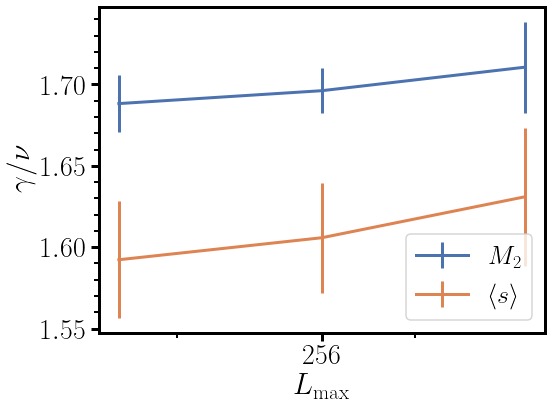

In [52]:
fig, ax = plt.subplots(figsize=(8,6))
ax.set_xscale('log')
ax.set_ylabel(r'$\gamma/\nu$')
ax.set_xticks([32, 64, 128, 256, 512])
ax.get_xaxis().set_minor_formatter(mpl.ticker.NullFormatter())
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax.tick_params(which='minor', length=5)
ax.tick_params(which='major', length=8)
ax.set_xlabel(r'$L_{\mathrm{max}}$')
for measure in gamma_measures:
    aux = np.array(data[attack][measure])
    X = aux[:,0]
    Y = aux[:,1]
    Y_err = aux[:,2]
    ax.errorbar(X, Y, Y_err, label=measures_dict[measure])
ax.legend()
plt.show()